In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch.nn.functional as F
from tqdm import tqdm
import sys
sys.path.append('/content')
from transformer import Transformer
from autoencoder import SparseAutoencoder
from data_utils import get_batch_iterator

In [5]:
context_length = 128
batch_size = 32
n_embed = 128
n_features = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_path = 'data/med_pile_train.h5'
resample_frequency = 1000
neuron_resampling_samples = 1024
lambda_reg = 0.003
steps = 50

In [8]:
transformer = Transformer(n_head=8, n_embed=n_embed, context_length=context_length, vocab_size=50304).to(device)
transformer.load_state_dict(torch.load('models/transformer_full.pt')['model_state_dict'])
transformer.eval()
autoencoder = SparseAutoencoder(n_features=n_features, n_embed=n_embed).to(device)
autoencoder.load_state_dict(torch.load('models/autoencoder.pt')['model_state_dict'])
autoencoder.eval()

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=512, bias=True)
  (decoder): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
)

In [9]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [10]:
def resample_autoencoder_weights(autoencoder, sample, neuron_idx):
    autoencoder.encoder.weight.data[neuron_idx] = sample.repeat(autoencoder.encoder.weight.data.shape[1] // sample.shape[0])[:autoencoder.encoder.weight.data.shape[1]] * 0.1

def reset_optimizer_state_for_neuron(neuron_idx, optimizer):
    pass

In [11]:
losses, recon_losses, reg_losses = [], [], []
batch_iterator = get_batch_iterator(train_path, batch_size, context_length, device=device)
for step in tqdm(range(steps)):
    xb, _ = next(batch_iterator)
    with torch.no_grad():
        x_embedding, _ = transformer.forward_embedding(xb)
    rand_idx = torch.randint(context_length, (batch_size,))
    filtered_xe = x_embedding[range(batch_size), rand_idx, :]
    outputs, recon_loss, reg_loss = autoencoder(filtered_xe, compute_loss=True)
    loss = recon_loss + lambda_reg * reg_loss
    losses.append(loss.item())
    recon_losses.append(recon_loss.item())
    reg_losses.append(reg_loss.item())

 50%|█████     | 25/50 [00:00<00:00, 37.62it/s]

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9
Finished epoch 10
Finished epoch 11
Finished epoch 12
Finished epoch 13
Finished epoch 14
Finished epoch 15
Finished epoch 16
Finished epoch 17
Finished epoch 18
Finished epoch 19
Finished epoch 20
Finished epoch 21
Finished epoch 22
Finished epoch 23
Finished epoch 24
Finished epoch 25
Finished epoch 26
Finished epoch 27
Finished epoch 28
Finished epoch 29
Finished epoch 30
Finished epoch 31
Finished epoch 32
Finished epoch 33
Finished epoch 34
Finished epoch 35
Finished epoch 36
Finished epoch 37
Finished epoch 38
Finished epoch 39
Finished epoch 40
Finished epoch 41
Finished epoch 42
Finished epoch 43
Finished epoch 44
Finished epoch 45
Finished epoch 46
Finished epoch 47


100%|██████████| 50/50 [00:01<00:00, 49.49it/s]

Finished epoch 48


Finished epoch 49
Finished epoch 50
Finished epoch 51
Finished epoch 52
Finished epoch 53
Finished epoch 54
Finished epoch 55
Finished epoch 56
Finished epoch 57
Finished epoch 58
Finished epoch 59
Finished epoch 60
Finished epoch 61
Finished epoch 62
Finished epoch 63
Finished epoch 64
Finished epoch 65
Finished epoch 66
Finished epoch 67
Finished epoch 68
Finished epoch 69
Finished epoch 70
Finished epoch 71
Finished epoch 72
Finished epoch 73
Finished epoch 74
Finished epoch 75
Finished epoch 76
Finished epoch 77
Finished epoch 78
Finished epoch 79
Finished epoch 80


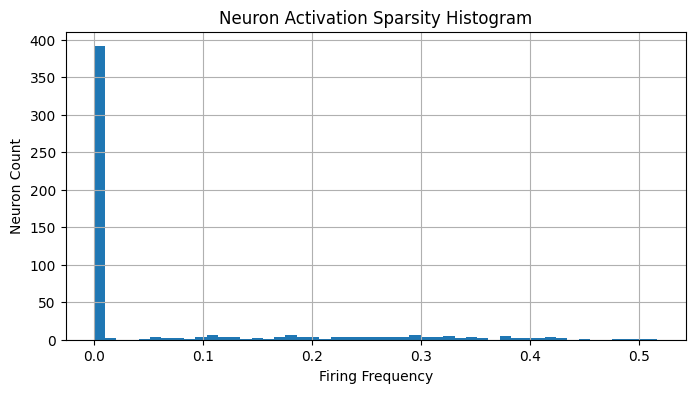

In [12]:
with torch.no_grad():
    all_activations = []
    for _ in range(neuron_resampling_samples // batch_size):
        xb, _ = next(batch_iterator)
        x_embedding, _ = transformer.forward_embedding(xb)
        rand_idx = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), rand_idx, :]
        codes = autoencoder.encode(filtered_xe)
        all_activations.append((codes > 0).float())

activation_tensor = torch.cat(all_activations, dim=0)
activation_density = activation_tensor.mean(dim=0).cpu().numpy()
plt.figure(figsize=(8,4))
plt.hist(activation_density, bins=50)
plt.title("Neuron Activation Sparsity Histogram")
plt.xlabel("Firing Frequency")
plt.ylabel("Neuron Count")
plt.grid(True)
plt.show()

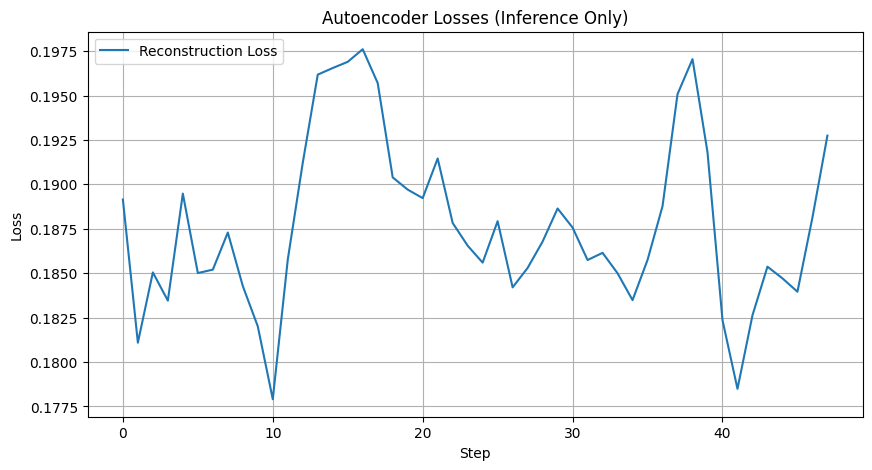

In [13]:
plt.figure(figsize=(10,5))
plt.plot(moving_average(recon_losses, 3), label='Reconstruction Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Autoencoder Losses (Inference Only)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Load tokenizer
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# Track activations & token
batch_iterator = get_batch_iterator(train_path, batch_size, context_length, device=device)
all_codes, all_tokens = [], []
for _ in range(10):
    xb, _ = next(batch_iterator)
    with torch.no_grad():
        x_embedding, _ = transformer.forward_embedding(xb)
        tokens = xb
        rand_idx = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), rand_idx, :]
        filtered_tokens = tokens[range(batch_size), rand_idx]
        codes = autoencoder.encode(filtered_xe)
        all_codes.append(codes)
        all_tokens.append(filtered_tokens)

# Get top-k
X = torch.cat(all_codes, dim=0)
T = torch.cat(all_tokens, dim=0)
k = 5
topk_per_neuron = {}
for neuron in range(X.shape[1]):
    neuron_vals = X[:, neuron]
    topk_idx = torch.topk(neuron_vals, k).indices
    topk_tokens = T[topk_idx].cpu().tolist()
    decoded = [tokenizer.decode([tid]) for tid in topk_tokens]
    topk_per_neuron[neuron] = decoded

for i in range(5):
    print(f"Neuron {i} Top-{k} tokens: {topk_per_neuron[i]}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Neuron 0 Top-5 tokens: ['Language', ' N', 'The', ' transforming', '.']
Neuron 1 Top-5 tokens: ['an', 'an', 'an', 'an', ' general']
Neuron 2 Top-5 tokens: ['Language', ' N', 'The', ' transforming', '.']
Neuron 3 Top-5 tokens: [' models', ' models', ' models', ' models', ' models']
Neuron 4 Top-5 tokens: ['Language', ' N', 'The', ' transforming', '.']


In [10]:
# Dead neuron
with torch.no_grad():
    all_activations = []
    for _ in range(neuron_resampling_samples // batch_size):
        xb, _ = next(batch_iterator)
        x_embedding, _ = transformer.forward_embedding(xb)
        rand_idx = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), rand_idx, :]
        codes = autoencoder.encode(filtered_xe)
        all_activations.append((codes > 0).float())

activation_tensor = torch.cat(all_activations, dim=0)
activation_density = activation_tensor.mean(dim=0)
num_dead = (activation_density == 0).sum().item()
print(f"Dead neuron count: {num_dead}/{activation_tensor.shape[1]}  ({num_dead/activation_tensor.shape[1]*100:.2f}%)")

Finished epoch 9
Finished epoch 10
Finished epoch 11
Finished epoch 12
Finished epoch 13
Finished epoch 14
Finished epoch 15
Finished epoch 16
Finished epoch 17
Finished epoch 18
Finished epoch 19
Finished epoch 20
Finished epoch 21
Finished epoch 22
Finished epoch 23
Finished epoch 24
Finished epoch 25
Finished epoch 26
Finished epoch 27
Finished epoch 28
Finished epoch 29
Finished epoch 30
Finished epoch 31
Finished epoch 32
Finished epoch 33
Finished epoch 34
Finished epoch 35
Finished epoch 36
Finished epoch 37
Finished epoch 38
Finished epoch 39
Finished epoch 40
Dead neuron count: 380/512  (74.22%)


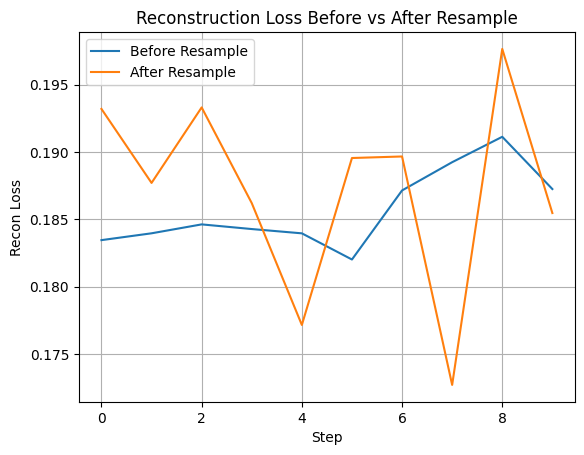

In [11]:
before_resample = recon_losses[10:20]
after_resample = recon_losses[20:30]
plt.plot(before_resample, label='Before Resample')
plt.plot(after_resample, label='After Resample')
plt.title('Reconstruction Loss Before vs After Resample')
plt.xlabel('Step')
plt.ylabel('Recon Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
with torch.no_grad():
    xb, _ = next(batch_iterator)
    x_embedding, _ = transformer.forward_embedding(xb)
    rand_idx = torch.randint(context_length, (batch_size,))
    filtered_xe = x_embedding[range(batch_size), rand_idx, :]
    codes = autoencoder.encode(filtered_xe)
    activation_density = (codes > 0).float().mean(dim=0)

    k = 64
    topk_indices = torch.topk(activation_density, k).indices
    ablated_codes = torch.zeros_like(codes)
    ablated_codes[:, topk_indices] = codes[:, topk_indices]
    recon = autoencoder.decoder(ablated_codes)
    recon_loss = F.mse_loss(recon, filtered_xe)
    print(f'Ablated recon loss (top-{k} only): {recon_loss:.4f}')

Finished epoch 41
Ablated recon loss (top-64 only): 0.3449


In [13]:
target_neuron = 0
with torch.no_grad():
    activations = []
    tokens = []
    for _ in range(10):
        xb, _ = next(batch_iterator)
        x_embedding, _ = transformer.forward_embedding(xb)
        rand_idx = torch.randint(context_length, (batch_size,))
        filtered_xe = x_embedding[range(batch_size), rand_idx, :]
        token = xb[range(batch_size), rand_idx]
        code = autoencoder.encode(filtered_xe)
        act = code[:, target_neuron]
        activations.append(act.cpu())
        tokens.append(token.cpu())

A = torch.cat(activations)
T = torch.cat(tokens)
topk = torch.topk(A, 10).indices
for tid in T[topk]:
    print(tokenizer.decode([tid.item()]))

Finished epoch 42
Finished epoch 43
Finished epoch 44
Finished epoch 45
Finished epoch 46
Finished epoch 47
Finished epoch 48
Finished epoch 49
Finished epoch 50
Finished epoch 51
.
 foundation
istic
 of
.
 fox
Language
an
 transforming
 of
